In [0]:
import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pickle
from keras.models import Sequential, Model, load_model
from keras.layers import *
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications import MobileNet, ResNet50, InceptionV3, MobileNetV2
from keras.utils import Sequence

In [0]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
from yolo_preprocess_new import ImageReader, NEW
from yolo_utils_new import decode, box_draw, BoundBox, compute_overlap

In [0]:
# Define the parameters, global variables to be used 
def initialize():
  IMAGE_DIMS = (416, 416)
  IMAGE_W = IMAGE_DIMS[1]
  IMAGE_H = IMAGE_DIMS[0]

  GRID_DIMS = (32,32)
  GRID_WSIZE = GRID_DIMS[1]
  GRID_HSIZE = GRID_DIMS[0]

  GRID_W = IMAGE_W//GRID_WSIZE
  GRID_H = IMAGE_H//GRID_HSIZE
  ANCHORS = np.load('/content/drive/My Drive/SVT/anchors_.npy')
  ANCHORS = ANCHORS.reshape(10)
  N_ANCHORS = len(ANCHORS)//2
  TRUE_BOX_BUFFER = 50
  LAMBDA_COORD = 1
  LAMBDA_NO_OBJECT = 1
  LAMBDA_OBJECT = 5
  BATCH_SIZE = 8
  config_dict = {
    'IMAGE_W'         : IMAGE_W, 
    'IMAGE_H'         : IMAGE_H,
    'GRID_WSIZE'      : GRID_WSIZE,
    'GRID_HSIZE'      : GRID_HSIZE,
    'GRID_W'          : GRID_W,  
    'GRID_H'          : GRID_H,
    'ANCHORS'         : ANCHORS,
    'N_ANCHORS'       : N_ANCHORS,
    'TRUE_BOX_BUFFER' : TRUE_BOX_BUFFER,
    'LAMBDA_COORD'    : LAMBDA_COORD,
    'LAMBDA_NO_OBJECT': LAMBDA_NO_OBJECT,
    'LAMBDA_OBJECT'   : LAMBDA_OBJECT,
    'BATCH_SIZE'      : BATCH_SIZE
  }

  return(config_dict)
config= initialize()

In [0]:
IMAGE_H = config['IMAGE_H']
IMAGE_W =config['IMAGE_W']
TRUE_BOX_BUFFER = config['TRUE_BOX_BUFFER']
GRID_H = config['GRID_H']
GRID_W = config['GRID_W']
ANCHORS = config['ANCHORS']
N_ANCHORS = config['N_ANCHORS']
LAMBDA_NO_OBJECT = 1.0
LAMBDA_OBJECT    = 5.0
LAMBDA_COORD     = 1.0
BATCH_SIZE = config['BATCH_SIZE']
print(N_ANCHORS, GRID_H, IMAGE_H)

5 13 416


In [0]:
def get_iou_scores(true_xy, true_wh, pred_xy, pred_wh):
  '''
    inputs - 
      true_xy,pred_xy, true_wh and pred_wh must have the same shape length

    p1 : pred_mins = (px1,py1)
    p2 : pred_maxs = (px2,py2)
    t1 : true_mins = (tx1,ty1) 
    t2 : true_maxs = (tx2,ty2) 
                  p1___________________________________
                  |                                    |
                  |   t1(rmin)________________         |
                  |          |                |        |
                  |          |                |rmax    |
                  |__________|________________|*_______|p2               
                             |                |    
                             |________________|t2
    intersect_mins : rmin = t1  = (tx1,ty1)
    intersect_maxs : rmax = * = (rmaxx,rmaxy)
    intersect_wh   : (rmaxx - tx1, rmaxy - ty1)

    outputs - 
      iou_scores - float 
        
    '''
  true_wh_half = true_wh / 2.
  true_mins    = true_xy - true_wh_half
  true_maxes   = true_xy + true_wh_half
    
  pred_wh_half = pred_wh / 2.
  pred_mins    = pred_xy - pred_wh_half
  pred_maxes   = pred_xy + pred_wh_half    
    
  intersect_mins  = tf.maximum(pred_mins,  true_mins)
  intersect_maxes = tf.minimum(pred_maxes, true_maxes)
  intersect_wh    = tf.maximum(intersect_maxes - intersect_mins, 0.)
  intersect_areas = intersect_wh[..., 0] * intersect_wh[..., 1]
    
  true_areas = true_wh[..., 0] * true_wh[..., 1]
  pred_areas = pred_wh[..., 0] * pred_wh[..., 1]

  union_areas = pred_areas + true_areas - intersect_areas
  iou_scores  = tf.truediv(intersect_areas, union_areas)    
  return(iou_scores)

In [0]:
def custom_loss(y_true, y_pred):
  '''
  computes yolo-loss
  inputs -
      y_true - ground-truth labels
      y_pred - prediction from model
      both of shape (BATCH_SIZE, GRID_H, GRID_W, N_ANCHORS, 5)
  outputs -
      loss - float value indicating loss
  '''
  # cell_x[:,i,j,:] = [[[j]]]
  cell_x = tf.cast(tf.reshape(tf.tile(tf.range(GRID_W), [GRID_H]), (1, GRID_H, GRID_W, 1, 1)), tf.float32)

  # cell_y[:,i,j,:] = [[[i]]]
  cell_y = tf.transpose(cell_x, (0,2,1,3,4))

  # for any n, i, j, k
  #    cell_grid[n, i, j, anchor, k] = j when k = 0
  # for any n, i, j, k
  #    cell_grid[n, i, j, anchor, k] = i when k = 1    
  cell_grid = tf.tile(tf.concat([cell_x,cell_y], -1), [BATCH_SIZE, 1, 1, N_ANCHORS, 1])

  mask_shape = tf.shape(y_true)[:4]
  coord_mask = tf.zeros(mask_shape)
  conf_mask  = tf.zeros(mask_shape)
  
  ### adjust x and y  
  # the bounding box bx and by are rescaled to range between 0 and 1 for given gird.
  pred_box_xy = tf.sigmoid(y_pred[..., :2]) + cell_grid # bx, by
    
  ### adjust w and h
  # exp to make width and height positive
  pred_box_wh = tf.exp(y_pred[..., 2:4]) * np.reshape(ANCHORS,[1,1,1,N_ANCHORS,2]) # bw, bh

  ### adjust confidence 
  pred_box_conf = tf.sigmoid(y_pred[..., 4])# prob bb

  true_box_xy    = y_true[..., 0:2] # bounding box x, y coordinate in grid cell scale 
  true_box_wh    = y_true[..., 2:4] # number of cells accross, horizontally and vertically

  iou_scores = get_iou_scores(true_box_xy, true_box_wh, pred_box_xy, pred_box_wh)
  true_box_conf = iou_scores * y_true[..., 4]

  coord_mask = tf.expand_dims(y_true[..., 4], axis=-1) * LAMBDA_COORD

  ### confidence mask: penalize predictors + penalize boxes with low IOU
  true_xy = true_boxes[..., 0:2]
  true_wh = true_boxes[..., 2:4]

  pred_xy = tf.expand_dims(pred_box_xy, 4)
  pred_wh = tf.expand_dims(pred_box_wh, 4)

  new_iou_scores = get_iou_scores(true_xy, true_wh, pred_xy, pred_wh)

  best_ious = tf.reduce_max(new_iou_scores, axis=4)

  conf_mask = conf_mask + tf.cast(best_ious < 0.6, tf.float32) * (1 - y_true[..., 4]) * LAMBDA_NO_OBJECT

  # penalize the confidence of the boxes which are reponsible for corresponding ground truth box
  conf_mask = conf_mask + y_true[..., 4] * LAMBDA_OBJECT

  ### Compute the final losses
  nb_coord_box = tf.reduce_sum(tf.cast(coord_mask > 0.0, tf.float32))
  nb_conf_box  = tf.reduce_sum(tf.cast(conf_mask  > 0.0, tf.float32))

  # xy loss
  loss_xy      = tf.reduce_sum(tf.square(true_box_xy-pred_box_xy) * coord_mask) / (nb_coord_box + 1e-6) / 2.
  # wh loss
  loss_wh      = tf.reduce_sum(tf.square(true_box_wh-pred_box_wh) * coord_mask) / (nb_coord_box + 1e-6) / 2.
  # conf loss
  loss_conf    = tf.reduce_sum(tf.square(true_box_conf-pred_box_conf) * conf_mask)  / (nb_conf_box  + 1e-6) / 2.

  loss = loss_xy + loss_wh + loss_conf
  return loss

In [0]:
# config dictionary for batch generator
generator_config = {
    'IMAGE_H'         : config['IMAGE_H'], 
    'IMAGE_W'         : config['IMAGE_W'],
    'GRID_H'          : config['GRID_H'],  
    'GRID_W'          : config['GRID_W'],
    'ANCHORS'         : config['ANCHORS'],
    'N_ANCHORS'       : config['N_ANCHORS'],
    'BATCH_SIZE'      : config['BATCH_SIZE'],
    'TRUE_BOX_BUFFER' : config['TRUE_BOX_BUFFER'],
}


In [0]:
# Loading the information lists - which are lists of dicts with each dict having info about an image
import pickle
with open('/content/drive/My Drive/SVT/train_images_.pickle', 'rb') as fp:
  train_images = pickle.load(fp)
with open('/content/drive/My Drive/SVT/val_images_.pickle', 'rb') as fp:
  valid_images = pickle.load(fp)
with open('/content/drive/My Drive/SVT/test_images_.pickle', 'rb') as fp:
  test_images = pickle.load(fp)

train_batch = NEW(train_images, generator_config)
valid_batch = NEW(valid_images, generator_config)

In [0]:
# veryfing BatchGenerator
[xx,bb], yy = train_batch.__getitem__(2)
print(xx.shape, bb.shape, yy.shape)

(8, 416, 416, 3) (8, 1, 1, 1, 50, 4) (8, 13, 13, 5, 5)


In [0]:
def check_object_in_grid_anchor_pair(irow, y_batch):
    '''
    sanity check for input pipeline
    inputs -
      irow - index of (irowth) training example
      y_batch - ground truth label - of shape (BATCH_SIZE, GRID_H, GRID_W, N_ANCHORS, 5)
    prints location of bboxes (igrid_h, igrid_w, ianchor) in the irowth image of x_batch using the irowth label of y_batch 
    '''
    for igrid_h in range(config["GRID_H"]):
        for igrid_w in range(config["GRID_W"]):
            for ianchor in range(config["N_ANCHORS"]):
                vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
                C = vec[4] ## ground truth confidence
                if C == 1:
                  print("igrid_h={:02.0f},igrid_w={:02.0f},iAnchor={:02.0f}".format(
                        igrid_h,igrid_w,ianchor))

In [0]:
def plot_image_with_grid_cell_partition(irow, x_batch):
  '''
  sanity check for input pipeline
  inputs - 
    irow - index of (irowth) training example 
    x_batch - image array of shape (BATCH_SIZE, IMAGE_H, IMAGE_W, 3), normalized by dividing by IMAGE_H/GRID_H and so on
  plots image and grid on the image
  '''
  img = x_batch[irow]
  plt.figure(figsize=(12,12))
  plt.imshow(img)
  for wh in ["W","H"]:
    GRID_       = config["GRID_"  + wh] ##  using config global dict
    IMAGE_      = config["IMAGE_" + wh] ##  using config global dict
    if wh == "W":
      pltax   = plt.axvline
      plttick = plt.xticks
    else:
      pltax   = plt.axhline
      plttick = plt.yticks
            
    for count in range(GRID_):
      l = IMAGE_*count/GRID_
      pltax(l,color="yellow",alpha=0.3) 
      plttick([(i + 0.5)*IMAGE_/GRID_ for i in range(GRID_)],
                ["iGRID{}={}".format(wh,i) for i in range(GRID_)])



In [0]:
def plot_grid(irow, y_batch):
  '''
  sanity check for input pipeline
  inputs -
    irow - index of (irowth) training example
    y_batch - ground truth label - of shape (BATCH_SIZE, GRID_H, GRID_W, N_ANCHORS, 5)
  for every bounding box - draw it on the above image, grid
  '''
  import seaborn as sns # just for choosing colours 
  color_palette = list(sns.xkcd_rgb.values())
  iobj = 0  ##  different colours for different boxes
  for igrid_h in range(config["GRID_H"]):
    for igrid_w in range(config["GRID_W"]):
      for ianchor in range(config["N_ANCHORS"]):
        vec = y_batch[irow,igrid_h,igrid_w,ianchor,:]
        C = vec[4] ## ground truth confidence
        if C == 1:
          x, y, w, h = vec[:4]
          multx = config["IMAGE_W"]/config["GRID_W"]  ## using config global dict
          multy = config["IMAGE_H"]/config["GRID_H"]  ## using config global dict
          c = color_palette[iobj]
          iobj += 1
          xmin = x - 0.5*w
          ymin = y - 0.5*h
          xmax = x + 0.5*w
          ymax = y + 0.5*h
          
          plt.plot(np.array([xmin,xmin])*multx,
                             np.array([ymin,ymax])*multy,color=c,linewidth=10)
          plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymin,ymin])*multy,color=c,linewidth=10)
          plt.plot(np.array([xmax,xmax])*multx,
                             np.array([ymax,ymin])*multy,color=c,linewidth=10)  
          plt.plot(np.array([xmin,xmax])*multx,
                             np.array([ymax,ymax])*multy,color=c,linewidth=10)

(8, 416, 416, 3)


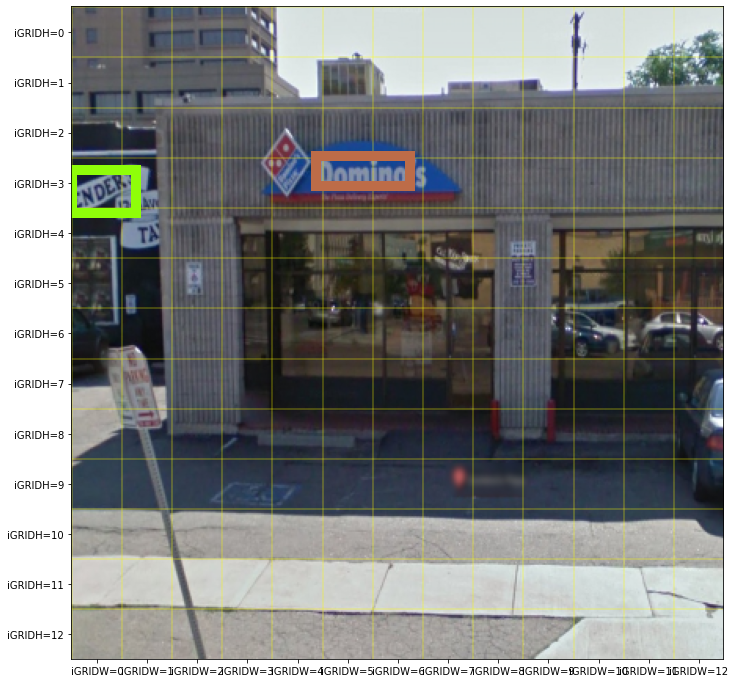

igrid_h=03,igrid_w=00,iAnchor=03
igrid_h=03,igrid_w=05,iAnchor=03


In [0]:
ibatch = 5
iframe = 5
[xb,bb], yb = train_batch.__getitem__(ibatch) 
print(xb.shape)
plot_image_with_grid_cell_partition(iframe, xb)
plot_grid(iframe, yb)
plt.show()
check_object_in_grid_anchor_pair(iframe, yb)

In [0]:
# TRY OUT OTHER PRE-TRAINED MODELS LIKE RESNET50, INCEPTIONV3 
######################
# def get_model(net_name, trainabl = True):

#   input_image = Input(shape=(IMAGE_H, IMAGE_W, 3))
#   true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4))

#   if net_name == 'MobileNet':
#     base = MobileNet(input_shape = (IMAGE_H, IMAGE_W, 3), input_tensor = input_image, include_top = False, weights = 'imagenet')

#   elif net_name == 'ResNet50':
#     base = ResNet50(input_shape = (IMAGE_H, IMAGE_W, 3), input_tensor = input_image, include_top = False, weights = 'imagenet')
#     base.layers.pop()

#   elif net_name == 'InceptionV3':
#     base = InceptionV3(input_shape = (IMAGE_H, IMAGE_W, 3), input_tensor = input_image, include_top = False, weights = 'imagenet')
  
#   elif net_name == 'MobileNetV2':
#      base = MobileNetV2(input_shape = (IMAGE_H, IMAGE_W, 3), input_tensor = input_image, include_top = False, weights = 'imagenet')

#   last_layer = base.output
#   if trainabl == False:
#     for layer in base.layers:
#       layer.trainable = False
#   x = Conv2D(256, (3,3), strides = (1,1), padding = 'same')(last_layer)
#   x = Dropout(0.2)(x)
#   x = BatchNormalization()(x)
#   x = LeakyReLU()(x)
#   x = Conv2D(128, (3,3), strides = (1,1), padding = 'same')(last_layer)
#   x = Dropout(0.2)(x)
#   x = BatchNormalization()(x)
#   x = LeakyReLU()(x)

#   # Layer 23
#   x = Conv2D(config['N_ANCHORS'] * 5, (1,1), strides=(1,1), padding='same', name='conv_23')(x)
#   output = Reshape((GRID_H, GRID_W, N_ANCHORS, 5))(x)

#   # small hack to allow true_boxes to be registered when Keras build the model 
#   # for more information: https://github.com/fchollet/keras/issues/2790
#   output = Lambda(lambda args: args[0])([output, true_boxes])
#   model = Model([input_image, true_boxes], output)

#   layer   = model.layers[-4] # the last convolutional layer
#   weights = layer.get_weights()

#   new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
#   new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)
#   layer.set_weights([new_kernel, new_bias])
#   return model, true_boxes

In [0]:
# YOLO MODEL
# check out the architecture here- https://medium.com/@y1017c121y/how-does-yolov2-work-daaaa967c5f7

# to be able to deploy a skip connection
def space_to_depth_x2(x):
  return tf.nn.space_to_depth(x, block_size=2)

def ConvBatchLReLu(x,filters,kernel_size,index,trainable):
  # when strides = None, strides = pool_size.
  x = Conv2D(filters, kernel_size, strides=(1,1), 
               padding='same', name='conv_{}'.format(index), 
               use_bias=False, trainable=trainable)(x)
  x = BatchNormalization(name='norm_{}'.format(index), trainable=trainable)(x)
  x = LeakyReLU(alpha=0.1)(x)
  return(x)
def ConvBatchLReLu_loop(x,index,convstack,trainable):
  for para in convstack:
    x = ConvBatchLReLu(x,para["filters"],para["kernel_size"],index,trainable)
    index += 1
  return(x)
def define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,N_ANCHORS, trainable=False):
  convstack3to5  = [{"filters":128, "kernel_size":(3,3)},  # 3
                      {"filters":64,  "kernel_size":(1,1)},  # 4
                      {"filters":128, "kernel_size":(3,3)}]  # 5
                    
  convstack6to8  = [{"filters":256, "kernel_size":(3,3)},  # 6
                      {"filters":128, "kernel_size":(1,1)},  # 7
                      {"filters":256, "kernel_size":(3,3)}]  # 8
    
  convstack9to13 = [{"filters":512, "kernel_size":(3,3)},  # 9
                      {"filters":256, "kernel_size":(1,1)},  # 10
                      {"filters":512, "kernel_size":(3,3)},  # 11
                      {"filters":256, "kernel_size":(1,1)},  # 12
                      {"filters":512, "kernel_size":(3,3)}]  # 13
        
  convstack14to20 = [{"filters":1024, "kernel_size":(3,3)}, # 14 
                       {"filters":512,  "kernel_size":(1,1)}, # 15
                       {"filters":1024, "kernel_size":(3,3)}, # 16
                       {"filters":512,  "kernel_size":(1,1)}, # 17
                       {"filters":1024, "kernel_size":(3,3)}, # 18
                       {"filters":1024, "kernel_size":(3,3)}, # 19
                       {"filters":1024, "kernel_size":(3,3)}] # 20
    
  input_image = Input(shape=(IMAGE_H, IMAGE_W, 3),name="input_image")
  true_boxes  = Input(shape=(1, 1, 1, TRUE_BOX_BUFFER , 4),name="input_hack")    
  # Layer 1
  x = ConvBatchLReLu(input_image,filters=32,kernel_size=(3,3),index=1,trainable=trainable)
    
  x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_416to208")(x)
  # Layer 2
  x = ConvBatchLReLu(x,filters=64,kernel_size=(3,3),index=2,trainable=trainable)
  x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_208to104")(x)
    
  # Layer 3 - 5
  x = ConvBatchLReLu_loop(x,3,convstack3to5,trainable)
  x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_104to52")(x)
    
  # Layer 6 - 8 
  x = ConvBatchLReLu_loop(x,6,convstack6to8,trainable)
  x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_52to26")(x) 

  # Layer 9 - 13
  x = ConvBatchLReLu_loop(x,9,convstack9to13,trainable)
        
  skip_connection = x
  x = MaxPooling2D(pool_size=(2, 2),name="maxpool1_26to13")(x)
    
  # Layer 14 - 20
  x = ConvBatchLReLu_loop(x,14,convstack14to20,trainable)

  # Layer 21
  skip_connection = ConvBatchLReLu(skip_connection,filters=64,
                                     kernel_size=(1,1),index=21,trainable=trainable)
  skip_connection = Lambda(space_to_depth_x2)(skip_connection)

  x = concatenate([skip_connection, x])

  # Layer 22
  x = ConvBatchLReLu(x,filters=1024,kernel_size=(3,3),index=22,trainable=trainable)

  # Layer 23
  x = Conv2D(N_ANCHORS* (4 + 1), (1,1), strides=(1,1), padding='same', name='conv_23')(x)
  output = Reshape((GRID_H, GRID_W, N_ANCHORS, 4 + 1),name="final_output")(x)

  # small hack to allow true_boxes to be registered when Keras build the model 
  # for more information: https://github.com/fchollet/keras/issues/2790
  output = Lambda(lambda args: args[0],name="hack_layer")([output, true_boxes])

  model = Model([input_image, true_boxes], output)
  return(model, true_boxes)


## true_boxes is the tensor that takes "b_batch"
## used only for computing loss function
model, true_boxes = define_YOLOv2(IMAGE_H,IMAGE_W,GRID_H,GRID_W,TRUE_BOX_BUFFER,N_ANCHORS,
                                  trainable=True)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        (None, 416, 416, 3)  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, 416, 416, 32) 864         input_image[0][0]                
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, 416, 416, 32) 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_23 (LeakyReLU)      (None, 416, 416, 32) 0           norm_1[0][0]                     
____________________________________________________________________________________________

In [0]:
# download yolo weights from https://pjreddie.com/media/files/yolov2.weights
# wget -P 'path_to_weight' https://pjreddie.com/media/files/yolov2.weights

In [0]:
path_to_weight = "/content/drive/My Drive/SVT/yolov2.weights"
class WeightReader:
  # class to read and set pre-trained weights 
  def __init__(self, weight_file):
    self.offset = 4
    self.all_weights = np.fromfile(weight_file, dtype='float32')
        
  def read_bytes(self, size):
    self.offset = self.offset + size
    return self.all_weights[self.offset-size:self.offset]
    
  def reset(self):
    self.offset = 4
                
weight_reader = WeightReader(path_to_weight)
print("all_weights.shape = {}".format(weight_reader.all_weights.shape))

all_weights.shape = (50983565,)


In [0]:
# load the weights
weight_reader.reset()
nb_conv = 23

for i in range(1, nb_conv+1):
  conv_layer = model.get_layer('conv_' + str(i))
    
  if i < nb_conv:
    norm_layer = model.get_layer('norm_' + str(i))
        
    size = np.prod(norm_layer.get_weights()[0].shape)

    beta  = weight_reader.read_bytes(size)
    gamma = weight_reader.read_bytes(size)
    mean  = weight_reader.read_bytes(size)
    var   = weight_reader.read_bytes(size)

    weights = norm_layer.set_weights([gamma, beta, mean, var])       
        
  if len(conv_layer.get_weights()) > 1:
    bias   = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
    kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
    kernel = kernel.transpose([2,3,1,0])
    conv_layer.set_weights([kernel, bias])
  else:
    kernel = weight_reader.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
    kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
    kernel = kernel.transpose([2,3,1,0])
    conv_layer.set_weights([kernel])


layer   = model.layers[-4] # the last convolutional layer
weights = layer.get_weights()

new_kernel = np.random.normal(size=weights[0].shape)/(GRID_H*GRID_W)
new_bias   = np.random.normal(size=weights[1].shape)/(GRID_H*GRID_W)

layer.set_weights([new_kernel, new_bias])

In [0]:
for layer in model.layers[-4:]:
  print(layer.get_weights())
  # check for nan weights in last layer -

[array([[[[ 0.00439494,  0.00556328,  0.00776818, ..., -0.00231922,
          -0.00718262,  0.00511713],
         [ 0.0008617 ,  0.00127922, -0.00181856, ..., -0.00248058,
           0.00974705, -0.00076799],
         [ 0.00401262, -0.00087776, -0.00193521, ...,  0.01261661,
           0.01050439, -0.00810056],
         ...,
         [-0.00039159, -0.00215939,  0.0042474 , ..., -0.00899837,
          -0.00879455, -0.00301955],
         [-0.00411588,  0.00152892, -0.0029681 , ...,  0.00225445,
          -0.00868314,  0.00058344],
         [-0.00538049,  0.00346308,  0.00403371, ...,  0.00827276,
           0.00039137, -0.00304784]]]], dtype=float32), array([ 0.0085626 , -0.00598376,  0.00173239, -0.01211029,  0.00152004,
       -0.00366516,  0.00389482,  0.00192325, -0.00827223,  0.00015107,
       -0.00524907,  0.00265369, -0.01096408, -0.0082949 , -0.0086061 ,
        0.00122816,  0.00786305, -0.00390739, -0.00070466,  0.00343304,
        0.001756  ,  0.01085004,  0.00736876,  0.00108

In [0]:
checkpoint = ModelCheckpoint('/content/drive/My Drive/SVT/yolo_models/yolov2_400ep.h5', 
                             monitor='val_loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', 
                             period=1)

opt = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(loss=custom_loss, optimizer=opt)

In [0]:
history = model.fit_generator(generator = train_batch, 
                    steps_per_epoch  = len(train_batch), 
                    epochs           = 400, 
                    verbose          = 1,
                    validation_data  = valid_batch,
                    validation_steps = len(valid_batch),
                    callbacks        = [checkpoint], 
                    max_queue_size   = 3)

In [0]:
model2 = load_model('/content/drive/My Drive/SVT/yolo_models/yolov2_200ep.h5', custom_objects = {'tf': tf, 'custom_loss': custom_loss})

In [0]:
model = load_model('/content/drive/My Drive/SVT/yolo_models/yolov2_400ep.h5', custom_objects = {'tf': tf, 'custom_loss': custom_loss})

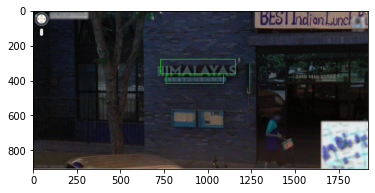

In [0]:
# Prediction block
def pred_img(model,path_to_image):
  image = cv2.imread(path_to_image)
  dummy_array = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4))

  input_image = cv2.resize(image, (416, 416))
  input_image = cv2.cvtColor(input_image, cv2.COLOR_BGR2RGB)
  input_image = input_image / 255.

  input_image = np.expand_dims(input_image, 0)

  outs = model.predict([input_image, dummy_array])

  boxes = decode(outs[0],
                      ANCHORS, 0.4, 0.4)            
  image = box_draw(image, boxes)
pred_img(model2, test_images[24]['filename'])

In [0]:
def get_predbox(bboxes):
  # convert list of BoundingBox objects to numpy array of shape (k,4) (arr) for computing iou
  # bboxes (list of bbox objects)
  boxlist = []
  for box in bboxes:
    boxlist.append([box.xmin, box.ymin, box.xmax, box.ymax])
  arr = np.array(boxlist).reshape((len(boxlist), 4))
  return arr

In [0]:
def get_truebox(all_objs):
  # convert true bbox coordinates to numpy array of shape (k,4) (arr) for computing iou
  # all_objs - list of dicts with label, coords
  # boxlist is list with each element as [xmin, ymin, xmax, ymax, label] - used in get_predlist 
  boxlist = []
  numlist = []
  for obj in all_objs:
    numlist.append([ float(obj ['xmin']) / IMAGE_W, float(obj ['ymin']) / IMAGE_H, float(obj ['xmax']) / IMAGE_W, float(obj ['ymax']) / IMAGE_H])
    boxlist.append([ float(obj ['xmin']) / IMAGE_W, float(obj ['ymin']) / IMAGE_H, float(obj ['xmax']) / IMAGE_W, float(obj ['ymax']) / IMAGE_H, obj['label']])
  arr = np.array(numlist).reshape((len(boxlist), 4))
  return arr, boxlist
  

In [0]:
def get_predlist(model, imlist):
  # to generate new information list with predicted coordinates 
  
  dummy = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4)) # GLOBAL
  templist = copy.deepcopy(imlist)
  imagereader = ImageReader(IMAGE_H, IMAGE_W) # GLOBAL 
  instance_count = 0

  for iminstance in imlist: # for dict in list:
    img, all_objs = imagereader.fit(iminstance)

    outs = model.predict([np.expand_dims(img,0), dummy])
    bboxes = decode(outs[0], ANCHORS, 0.3, 0.3) # bboxes is list of box objects

    predarr = get_predbox(bboxes) # GLOBAL FUNTION
    truearr, boxlist = get_truebox(all_objs) # GLOBAL FUNCTION
    result = compute_overlap(predarr, truearr)

    templist[instance_count]['pred_object'] = []
    for row in range(result.shape[0]): # for every row of the matrix: i.e for every predbox
      idx = np.argmax(result[row])
      rowdict={
          'xmin'  : int(predarr[row][0]*iminstance['width']),
          'ymin'  : int(predarr[row][1]*iminstance['height']),
          'xmax'  : int(predarr[row][2]*iminstance['width']),
          'ymax'  : int(predarr[row][3]*iminstance['height']),
          'label' : boxlist[idx][4]
      }
      templist[instance_count]['pred_object'].append(rowdict)
    instance_count+=1
  return templist

In [0]:
finallist_400 = get_predlist(model, test_images)

In [0]:
finallist_200 = get_predlist(model2, test_images)

In [0]:
def show_one_result(imlist, ind):
  # tester function to view image cropped using predicted box results
  fname = imlist[ind]['filename']
  img = cv2.imread(fname)
  imgs = []
  for obj in imlist[ind]['pred_object']:

    tempy = max(0, obj['ymin'])
    tempx = max(0, obj['xmin'])
    c_img = img[tempy:obj['ymax'], tempx:obj['xmax']].copy()
    c_img = cv2.cvtColor(c_img, cv2.COLOR_BGR2GRAY)
    c_img = cv2.resize(c_img, (100,32))
    mean, std = cv2.meanStdDev(c_img)
    c_img = (c_img-mean)/std
    imgs.append(c_img)
  return imgs

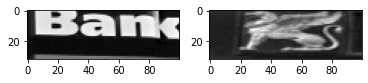

In [0]:
imgs = show_one_result(finallist_400, 8)
if len(imgs)>1:
  fig, ax = plt.subplots(1, len(imgs))
  for i in range(len(imgs)):
    ax[i].imshow(imgs[i], cmap = 'gray')
else:
  plt.imshow(imgs[0], cmap = 'gray')

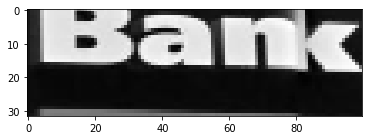

In [0]:
imgs = show_one_result(finallist_200, 8)
if len(imgs)>1:
  fig, ax = plt.subplots(1, len(imgs))
  for i in range(len(imgs)):
    ax[i].imshow(imgs[i], cmap = 'gray')
else:
  plt.imshow(imgs[0], cmap = 'gray')

In [0]:
def show_results(model, imlist):
  # display results of prediction- show average iou of each prediction with object threshold = 0.5 (can potentially be changed)
  # If threshold not reached, threshold set to maximum confidence score for computing iou
  score = 0

  dummy = np.zeros((1,1,1,1,TRUE_BOX_BUFFER,4)) # GLOBAL
  templist = copy.deepcopy(imlist)
  imagereader = ImageReader(IMAGE_H, IMAGE_W) # GLOBAL 
  instance_count = 0

  for iminstance in imlist: # for dict in list:
    img, all_objs = imagereader.fit(iminstance)

    outs = model.predict([np.expand_dims(img,0), dummy])
    bboxes = decode(outs[0], ANCHORS, 0.1, 0.4) # bboxes is list of box objects

    predarr = get_predbox(bboxes) # GLOBAL FUNTION
    truearr, _ = get_truebox(all_objs) # GLOBAL FUNCTION
    result = compute_overlap(predarr, truearr)

    screen = 0.5
    if screen > result.max():
      screen = result.max()
    final = result[result>=screen]
    score += np.sum(final) / len(final)

    print("\nAverage IOU for this image =", np.sum(final)/len(final))
    instance_count += 1
  print('overall Average IOU score = ', score/len(imlist))

In [0]:
show_results(model, test_images)


Average IOU for this image = 0.5797204187803194

Average IOU for this image = 0.5858838906163397

Average IOU for this image = 0.3477088593054371

Average IOU for this image = 0.3609806993586704

Average IOU for this image = 0.45918071397074295

Average IOU for this image = 0.7037704593469033

Average IOU for this image = 0.308212204143208

Average IOU for this image = 0.701957512519426

Average IOU for this image = 0.5421391938968493

Average IOU for this image = 0.6105872004294214

Average IOU for this image = 0.18693318573307488

Average IOU for this image = 0.4693229911846103

Average IOU for this image = 0.6093081903453503

Average IOU for this image = 0.6374681020291662

Average IOU for this image = 0.46501795407016566

Average IOU for this image = 0.6623598403319793

Average IOU for this image = 0.5810298331891995

Average IOU for this image = 0.7017018695607602

Average IOU for this image = 0.4510897074896562

Average IOU for this image = 0.4569716522901001

Average IOU for th

In [0]:
show_results(model2, test_images)


Average IOU for this image = 0.7223313341997082

Average IOU for this image = 0.5816676066487488

Average IOU for this image = 0.38753088871029384

Average IOU for this image = 0.48646831647366057

Average IOU for this image = 0.4517025205270169

Average IOU for this image = 0.6573073806341605

Average IOU for this image = 0.32864474143480515

Average IOU for this image = 0.6643114268594057

Average IOU for this image = 0.5530945468752483

Average IOU for this image = 0.48798962986901157

Average IOU for this image = 0.15209183442875712

Average IOU for this image = 0.5030870408576064

Average IOU for this image = 0.5693458905274115

Average IOU for this image = 0.6162465588255658

Average IOU for this image = 0.459171253263226

Average IOU for this image = 0.6852596393000455

Average IOU for this image = 0.4437714746510982

Average IOU for this image = 0.6745763500808346

Average IOU for this image = 0.46762754118958655

Average IOU for this image = 0.46165028429529525

Average IOU f

In [0]:
# save predicted lists to file for later use
with open('/content/drive/My Drive/SVT/yolo_models/finallist_400ep.pickle', 'wb') as fp:
  pickle.dump(finallist_400, fp)

with open('/content/drive/My Drive/SVT/yolo_models/finallist_200ep.pickle', 'wb') as fp:
  pickle.dump(finallist_200, fp)